In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import soundfile
from IPython.display import Audio

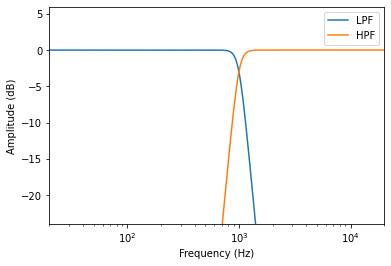

In [2]:
# BASICFILTERBANK
# This script creates a two-band filter bank using a LPF and HPF. The
# Butterworth filter design function is used to create the LPF and HPF, both
# with the same cutoff frequency. The magnitude response of each filter is
# plotted together.
#
# See also BUTTER, FREQZ

Fs = 48000
Nyq = Fs/2

n = 8
Wn = 1000/Nyq

[bLow, aLow] = signal.butter(n, Wn, output='ba')
[bHi, aHi] = signal.butter(n, Wn, 'highpass', output='ba')

[W, hLow] = signal.freqz(b=bLow, a=aLow, worN=4096, fs=Fs)
[_,hHi] = signal.freqz(b=bHi, a=aHi, worN=4096, fs=Fs)

plt.semilogx(W, 20*np.log10(abs(hLow)), W, 20*np.log10(abs(hHi)))
plt.axis([20, 20000, -24, 6])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.legend(['LPF', 'HPF'])
plt.show()

/var/folders/vs/l1t_wf8n20580_20pnqg7hfr0000gn/T/ipykernel_11875/722574948.py:27: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(W, 20*np.log10(abs(H)))
/var/folders/vs/l1t_wf8n20580_20pnqg7hfr0000gn/T/ipykernel_11875/722574948.py:27: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(W, 20*np.log10(abs(H)))
/var/folders/vs/l1t_wf8n20580_20pnqg7hfr0000gn/T/ipykernel_11875/722574948.py:27: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(W, 20*np.log10(abs(H)))
/var/folders/vs/l1t_wf8n20580_20pnqg7hfr0000gn/T/ipykernel_11875/722574948.py:27: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(W, 20*np.log10(abs(H)))


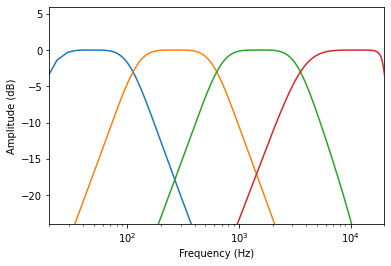

In [3]:
# FILTERBANKEXAMPLE
# This script creates a two-band filter bank using a LPF and HPF.
#
# See also BUTTER

Fs = 48000
Nyq = Fs/2

m = 2 # filter order
numBands = 4

# Logarithmically spaced cutoff frequencies
# 2 * 10^1 - 2 * 10^4 (20-20k Hz)
freq = 2 * np.logspace(1, 4, numBands+1)

b = np.zeros([numBands+1, numBands+1])
a = np.zeros([numBands+1, numBands+1])

for band in range(numBands):
    low = freq[band] / Nyq
    high = freq[band + 1] / Nyq
    Wn = [low, high]

    b[band, :], a[band, :] = signal.butter(m, Wn, btype='bandpass')

    W, H = signal.freqz(b[band, :], a[band, :], worN=4096, fs=Fs)
    plt.semilogx(W, 20*np.log10(abs(H)))


plt.axis([20, 20000, -24, 6])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.show()

In [25]:
# FILTEREXAMPLE
# This script demonstrates how to use built-in IIR filter design
# function to create the impulse response for an LPF. Then, the
# filtering is performed on an audio signal using the
# 'signal.lfilter' function.
[x, Fs] = soundfile.read('AcGtr.wav')
Nyq = Fs/2

m = 4 # Order of the filter

freqHz = 500 # frequency in Hz
Wn = freqHz/Nyq

[b, a] = signal.butter(m, Wn)
y = signal.lfilter(b, a, x)

Audio(y, rate=Fs)

In [2]:
# IMPZ

def impz(b,a):
    impulse = np.repeat(0., 60)
    impulse[0] = 1.
    x = np.arange(0, 60)

    response = signal.lfilter(b, a, impulse)

    plt.figure(figsize=(10,6))
    plt.subplot(2,2,1)
    plt.stem(x, response, 'm', use_line_collection=True)
    plt.xlabel(r'n (samples)', fontsize=15)
    plt.ylabel('Amplitude', fontsize=15)
    plt.title(r'Impulse Response', fontsize=15)

    plt.show()

    return response


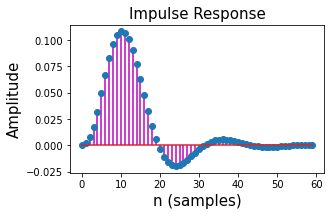

In [4]:
# IMPZEXAMPLE
# This script demonstrates how to use the 'impz' function to
# approximate an IIR system as an FIR system. Then filtering is
# performed on an audio signal using the convolution operation.
#
# See also IMPZ, CONV, BUTTER

# Import audio file
[x, Fs] = soundfile.read('AcGtr.wav')
Nyq = Fs/2

m = 4 # order of the filter

freqHz = 2000 # frequency in Hz
Wn = freqHz/Nyq

[b,a] = signal.butter(m, Wn)
h = impz(b,a) # approximate system

y = np.convolve(x, h)
Audio(y, rate=Fs)

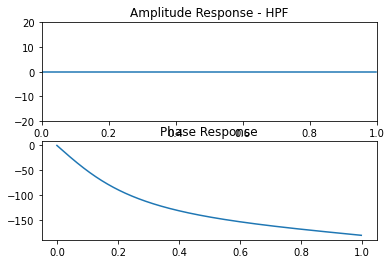

In [12]:
# IIRFILTERS

g = -0.5
alpha = 0.25
# [W, H] = signal.freqz(1, [1,-1])
# [W, H] = signal.freqz(1, [1,1])
# [W, H] = signal.freqz(1, [1, alpha])
# [W, H] = signal.freqz(1, [1,0,0,0,1]) # Inverted Comb Filter
[W, H] = signal.freqz([g,1], [1, g])

Hamp = abs(H)
Hphase = np.angle(H)

plt.figure(2)
plt.subplot(2,1,1)
plt.plot(W/np.pi, 20*np.log10(Hamp))
plt.axis([0,1,-20, 20])
plt.title('Amplitude Response - HPF')
plt.subplot(2,1,2)
plt.plot(W/np.pi, Hphase*(180/np.pi))
plt.title('Phase Response')
plt.show()

In [11]:
# BIQUADFILTER
# This function implements a bi-quad filter based on the Audio EQ Cookbook
# Coefficients. All filter types can be specified (LPF, HPF, BPF, etc.) and
# three different topologies are included.
#
# Input Variables
#   f0: filter frequency
#   Q: bandwidth parameter
#   dBGain: gain value on the decibel scale
#   type: 'lpf', 'hpf', 'pkf', 'bp1', 'bp2', 'apf', 'lsf', 'hsf'
#   form: 1 (Direct Form I), 2 (DFII), 3 (Transposed DFII)

def biquadFilter(x, Fs, f0, Q, dBGain, type, form):
    N = len(x)
    out = np.zeros(N)

    w0 = 2 * np.pi * f0/Fs # Angular freq. (radians/sample)
    alpha = np.sin(w0)/(2 * Q) # Filter Width
    A = np.sqrt(pow(10, dBGain/20))

    if type == 'lpf':
        b0 = (1 - np.cos(w0))/2
        b1 = 1 - np.cos(w0)
        b2 = (1 - np.cos(w0))/2
        a0 = 1 + alpha
        a1 = -2 * np.cos(w0)
        a2 = 1 - alpha

    elif type == 'hpf':
        b0 = (1 + np.cos(w0))/2
        b1 = -(1 + np.cos(w0))
        b2 = (1 + np.cos(w0))/2
        a0 = 1 + alpha
        a1 = -2 * np.cos(w0)
        a2 = 1 - alpha

    elif type == 'pkf':
        b0 = 1 + alpha * A
        b1 = -2 * np.cos(w0)
        b2 = 1 - alpha * A
        a0 = 1 + alpha/A
        a1 = -2 * np.cos(w0)
        a2 = 1 - alpha/A

    elif type == 'bp1':
        b0 = np.sin(w0)/2
        b1 = 0
        b2 = -np.sin(w0)/2
        a0 = 1 + alpha
        a1 = -2 * np.cos(w0)
        a2 = 1 - alpha

    elif type == 'bp2':
        b0 = alpha
        b1 = 0
        b2 = -alpha
        a0 = 1 + alpha
        a1 = -2 * np.cos(w0)
        a2 = 1 - alpha

    elif type == 'nch':
        b0 = 1
        b1 = -2 * np.cos(w0)
        b2 = 1
        a0 = 1 + alpha
        a1 = -2 * np.cos(w0)
        a2 = 1 - alpha

    elif type == 'apf':
        b0 = 1 - alpha
        b1 = -2 * np.cos(w0)
        b2 = 1 + alpha
        a0 = 1 + alpha
        a1 = -2 * np.cos(w0)
        a2 = 1 - alpha

    elif type == 'lsf':
        b0 = A * ((A + 1) - (A-1) * np.cos(w0) + 2 * np.sqrt(A) * alpha)
        b1 = 2 * A * ((A-1) - (A+1)*np.cos(w0))
        b2 = A * ((A+1) - (A-1) * np.cos(w0) + 2 * np.sqrt(A) * alpha)
        a0 = (A+1) + (A-1)*np.cos(w0) + 2 * np.sqrt(A) * alpha
        a1 = -2 * ((A-1) + (A+1) * np.cos(w0))
        a2 = (A+1) + (A-1) * np.cos(w0) - 2 * np.sqrt(A) * alpha

    elif type == 'hsf':
        b0 = A * ((A + 1) + (A-1) * np.cos(w0) + 2 * np.sqrt(A) * alpha)
        b1 = -2 * A * ((A-1) + (A+1)*np.cos(w0))
        b2 = A * ((A+1) + (A-1) * np.cos(w0) - 2 * np.sqrt(A) * alpha)
        a0 = (A+1) - (A-1)*np.cos(w0) + 2 * np.sqrt(A) * alpha
        a1 = 2 * ((A-1) - (A+1) * np.cos(w0))
        a2 = (A+1) - (A-1) * np.cos(w0) - 2 * np.sqrt(A) * alpha

    else:
        b0 = 1
        b1 = 0
        b2 = 0
        a0 = 1
        a1 = 0
        a2 = 0

    if form == 1:
        x2 = 0
        x1 = 0
        y2 = 0
        y1 = 0

        for n in range(N):
            out[n] = (b0/a0) * x[n] + (b1/a0) * x1 + (b2/a0) * x2 + (-a1/a0) * y1 + (-a2/a0) * y2
            x2 = x1
            x1 = x[n]
            y2 = y1
            y1 = out[n]

    elif form == 2:
        w1 = 0
        w2 = 0
        for n in range(N):
            w = x[n] + (-a1/a0) * w1 + (-a2/a0) * w2
            out[n] = (b0/a0) * w + (b1/a0) * w1 + (b2/a0) * w2
            w2 = w1
            w1 = w

    elif form == 3:
        d1 = 0
        d2 = 0
        for n in range(N):
            out[n] = (b0/a0) * x[n] + d1
            d1 = (b1/a0) * x[n] + (-a1/a0) * out[n] + d2
            d2 = (b2/a0) * x[n] + (-a2/a0) * out[n]

    else:
        out = x

    return out


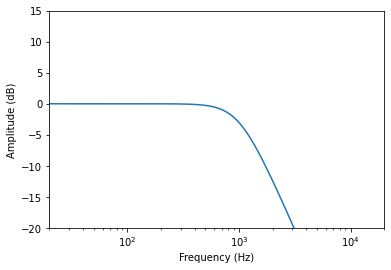

In [12]:
# BIQUADEXAMPLE
# This script demonstrates the use of the bi-quad filter function. Various
# filter types and topologies can be tested.
#
# See also BIQUADFILTER

# Impulse response of bi-quad
x = np.append(1, np.zeros(4096))

# Filter parameters
Fs = 48000
f = 1000 # frequency in Hz
Q = 0.707
dBGain = -6

# FILTER TYPE >>> 'lpf', 'hpf', 'pkf', 'bp1', 'bp2', 'apf', 'lsf', 'hsf'
type = 'lpf'
# TOPOLOGY >> 1 - Direct Form I, 2 - II, 3 Transposed II
form = 3

y = biquadFilter(x, Fs, f, Q, dBGain, type, form)
W, H = signal.freqz(y, 1, 4096, fs=Fs)

# Plot amplitude response of filter
plt.semilogx(W, 20 * np.log10(abs(H)))
plt.axis([20, 20000, -20, 15])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.show()

In [47]:
# SLEWRATEDISTORTION
# This function implements slew rate distortion. Frequencies
# greater than the 'maxFreq' parameter are distorted.
# Frequencies less than 'maxFreq' are not distorted. This type
# of distortion occurs in op-amps used for audio.
#
# Input variables
#   x: input signal to be processed
#   Fs: sampling rate
#   maxFreq: the limiting/highest frequency before distortion

def slewRateDistortion(x, Fs, maxFreq):
    Ts = 1/Fs
    peak = 1
    slewRate = maxFreq * 2 * np.pi * peak # convert freq. to slew rate

    slope = slewRate * Ts # Convert slew rate to slope/sample

    out = np.zeros(np.size(x)) # Total number of samples
    prevOut = 0 # Initialize feedback delay sample

    for n in range(len(x)):
        dlta = x[n] - prevOut
        if dlta > slope: # Dont let dlta exceed max slope
            dlta = slope
        elif dlta < -slope:
            dlta = -slope

        out[n] = prevOut + dlta
        prevOut = out[n] # Save current 'out' for next loop

    return out

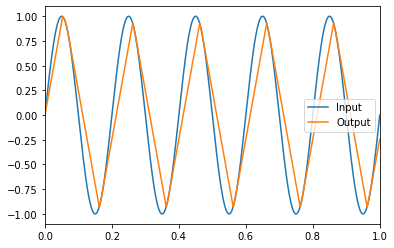

In [48]:
# SLEWRATEEXAMPLE
# This script demonstrates how to use the slewRateDistortion
# function. Two examples are provided, with a sine wave and a
# square wave.
#
# See also SLEWRATEDISTORTION
Fs = 48000
Ts = 1/Fs
f = 5
t = np.arange(0, Fs) * Ts

x = np.sin(2 * np.pi * f * t)
# x = np.sign(np.sin(2 * np.pi * f * t))

maxFreq = 3
y = slewRateDistortion(x, Fs, maxFreq)

plt.plot(t, x)
plt.plot(t,y)
plt.axis([0, 1, -1.1, 1.1])
plt.legend(['Input', 'Output'])
plt.show()

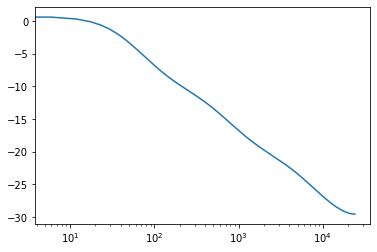

In [19]:
# PINKNOISE2
# This script synthesizes an approximation of pink noise
# using an IIR filter.
#
# Pink noise can be created by filtering white noise. The
# amplitude response of the filter decreases by 10 dB/decade
# or -3 dB/octave.

Fs = 48000
Nyq = Fs/2
sec = 5
white = np.random.randn(sec*Fs)
b = [0.04992035, -0.095993537, 0.050612699, -0.004408786]
a = [1, -2.494956002, 2.017265875, -0.522189400]

F, H = signal.freqz(b, a, 4096, fs=Fs)

plt.semilogx(F, 20 * np.log10(abs(H)))
# plt.axis([20, 20000, -30, 0])

pink = signal.lfilter(b,a,white)

In [32]:
# LUFS
# This function calculates the loudness of a mono or stereo
# audio signal based on the LUFS/LKFS standard. The analysis
# involves multiple steps. First, the input signal is
# processed using the pre-filter followed by the RLB filter.
# Then, a mean-square calculation is performed. Finally,
# all the channels are summed together and loudness is converted
# to units of decibels (dB).
#
# See also LUFSEXAMPLE

def lufs(x):
    # Number of samples
    N = len(x)
    # Determine whether mono or stereo
    numChannels = len(x.shape)

    # Initialize pre-filter
    b0 = 1.53512485958697
    a1 = -1.69065929318241
    b1 = -2.69169618940638
    a2 = 0.73248077421585
    b2 = 1.19839281085285
    a0 = 1

    b = [b0, b1, b2]
    a = [a0, a1, a2]

    # Perform pre-filtering
    w = np.zeros(np.shape(x))
    for channel in range(numChannels): # Loop in case it is stereo
        if numChannels == 1:
            w = signal.lfilter(b, a, x)
        elif numChannels == 2:
            w[:, channel] = signal.lfilter(b, a, x[:, channel])

    # RLB filter
    b0 = 1.0
    a1 = -1.99004745483398
    b1 = -2.0
    a2 = 0.99007225036621
    b2 = 1.0
    a0 = 1

    b = [b0, b1, b2]
    a = [a0, a1, a2]

    # Perform RLB filtering
    y = np.zeros(np.shape(x))
    for channel in range(numChannels):
        if numChannels == 1:
            y = signal.lfilter(b,a, w)
        elif numChannels == 2:
            y[:, channel] = signal.lfilter(b, a, w[:, channel])

    # Perform mean-square amplitude analysis
    z = np.zeros([1, numChannels])
    for channel in range(numChannels):
        # Add together the square of the samples
        # then divide by the number of samples
        if numChannels == 1:
            z = np.sum(pow(y, 2))/N
        elif numChannels == 2:
            z[:, channel] = np.sum(pow(y[:, channel], 2)) / N

    # Determine loudness (dB) by summing all channels
    loudness = -0.691 + 10 * np.log10(np.sum(z))

    return loudness

In [43]:
# LUFSEXAMPLE
# This script demonstrates the use of the lufs function
# for calculating loudness based on the LUFS/LKFS standard.
# Four examples are shown. First, a mono recording of a
# guitar is analyzed. Second, a stereo recording of
# drums is analyzed.
#
# Then, two more examples are demonstrated using test signals
# provided by the European Broadcast Union (EBU) for the sake
# of verifying proper measurement. A filtered pink noise signal
# is measured with a loudness of -23 LUFS. Finally, a sine wave
# signal is measured with a loudness of -40 LUFS.
#
# See also LUFS

# Example 1 - Guitar
sig_1, Fs = soundfile.read('AcGtr.wav')
loudnessGuit = lufs(sig_1)
print('LUFS of Example 1: ' + str(loudnessGuit))

# Example 2 - Stereo drums
sig_2, Fs = soundfile.read('distDrums.wav')
loudnessDrums = lufs(sig_2)
print('LUFS of Example 2: ' + str(loudnessDrums))


LUFS of Example 1: -20.371316628537027
LUFS of Example 2: -31.0777178801274
